In this case study, our aim is to show a system imbalance direction heuristic forecasts performance for 2 methods.

The forecasting rule for first one is t-3 (3hrs) and the second one is d-7 (7days)

1)Fetch imbalance direction data from EPİAS by using request library of Python

In [251]:
import requests
from datetime import datetime, timedelta
import copy

# Define the URL
url = 'https://seffaflik.epias.com.tr/transparency/service/market/smp'

# Define the start and end date
start_date = '2022-01-01'
end_date = '2022-11-01'

# Define the parameters to be sent in the request
params = {'startDate': start_date, 'endDate': end_date}

# Send a GET request to the URL
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Get the data in JSON format
    data = response.json()
#     print(data)
else:
    print("Request failed with status code:", response.status_code)
    


2a) Get the data from JSON and evaluate heuristic forecast performance for t-3 rule

Accuracy for the whole data was: % 80.77

In [252]:
# Strip smpList from JSON 
smp_list = data['body']['smpList']
#print(smp_list)
# I strip directions from the list just to check if it contains
# anything other than YAL(Yük Al), YAT(Yük At) and DNG(Denge)
# As stated in the case study description
# I'm changing 'YAT' to 1 'YAL' to -1 and 'DNG' to 0
# Making this change is also good for calculating forecasting error, MAE, RMSE
for i in smp_list:
    if i['smpDirection'] == 'YAT':
        i['smpDirection'] = 1
    elif i['smpDirection'] == 'YAL':
        i['smpDirection'] = -1
    elif i['smpDirection'] == 'DNG':
        i['smpDirection'] = 0
smp_directions = [i['smpDirection'] for i in smp_list]
smp_directions_bkp = [i['smpDirection'] for i in smp_list]
#print(smp_directions)

# We need to use copy package's deepcopy method since smp_list is a list of lists
smp_list_frcst = copy.deepcopy(smp_list)

i = 0
k = 3
while k < len(smp_list_frcst):
    smp_list_frcst[k]['smpDirection'] = smp_list[i]['smpDirection']
    i+=1
    k+=1

# We need to prune first 3 entries to have only the forecasted values
smp_list_frcst = copy.deepcopy(smp_list_frcst[3:])
# Get a copy for the t-test that will be conducted later on
forecast1 = [i['smpDirection'] for i in smp_list_frcst]
forecast1bkp = [i['smpDirection'] for i in smp_list_frcst]

# Check forecast directions and smp_directions first few samples together
smp_directions_frcst = [i['smpDirection'] for i in smp_list_frcst]
print('Actual Directions length: ',len(smp_directions))
print(smp_directions[:30])
print('Forecasts Directions length: ',len(smp_directions_frcst))
print(smp_directions_frcst[:30])



# Check the accuracy for whole data

i = 3
k = 0
cnt = 0
while k < len(smp_list_frcst):
    if smp_list_frcst[k]['smpDirection'] == smp_list[i]['smpDirection']:
        cnt+=1
    i+=1
    k+=1
# print(cnt)
print ('Accuracy for the whole data: ',cnt, '/',len(smp_list_frcst),'= %',
       round((cnt/len(smp_list_frcst)*100),2))


Actual Directions length:  7320
[1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forecasts Directions length:  7317
[1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy for the whole data:  5910 / 7317 = % 80.77


2b) Now we will check the accuracy for each hour. The results are shown in the output after the code below. The red line is the mean accuracy considering all hours. 

To do this part I've used a dictionary approach to store the total number of data corresponding to each hour. Both for the actual data, the forecast count and for accuracy percentages. 

In [253]:
# Check the accuracy for each hour
from datetime import datetime
# Create an empty dictionary to store the counts for each hour
hour_counts = {}

# Iterate through the list of dicts
for entry in smp_list_frcst:
    # Extract the hour from the 'date' field
    hour = datetime.strptime(entry['date'], '%Y-%m-%dT%H:%M:%S.%f%z').hour
    # If the hour is already in the dictionary, increment the count
    if hour in hour_counts:
        hour_counts[hour] += 1
    # If the hour is not in the dictionary, add it with a count of 1
    else:
        hour_counts[hour] = 1

# Print the dictionary of hour counts
hour_counts = dict(sorted(hour_counts.items()))
print(hour_counts)
total = sum(hour_counts.values())
print('Total actual count: ',total)

# Initiate hour accuracy dictionary
hour_acc_counts = {hour: 0 for hour in range(24)}
#print(hour_acc_counts)
i=0
while i < len(smp_list_frcst):
    hour = datetime.strptime(smp_list_frcst[i]['date'], '%Y-%m-%dT%H:%M:%S.%f%z').hour
    if smp_list_frcst[i]['smpDirection'] == smp_list[i+3]['smpDirection']:
        hour_acc_counts[hour] += 1
    i+=1

print(hour_acc_counts)

# A quick checksum to see if our finding are in accordance with the our findings in the 'whole data' part
# it was accurate for 5910 entries in total
total = sum(hour_acc_counts.values())
print('Total accurate count: ',total)

hour_acc_prcnt = {}
for key in hour_counts.keys():
    hour_acc_prcnt[key] = hour_acc_counts[key] / hour_counts[key]

hour_acc_prcnt = {k: round(v, 2) for k, v in hour_acc_prcnt.items()}
print('Accuracy by hour for t-3')
print(hour_acc_prcnt)
total_value = 0
for value in hour_acc_prcnt.values():
    total_value += value

avg_hour_prcnt = round(total_value / len(hour_acc_prcnt),2)
print("Average value:", avg_hour_prcnt)

{0: 304, 1: 304, 2: 304, 3: 305, 4: 305, 5: 305, 6: 305, 7: 305, 8: 305, 9: 305, 10: 305, 11: 305, 12: 305, 13: 305, 14: 305, 15: 305, 16: 305, 17: 305, 18: 305, 19: 305, 20: 305, 21: 305, 22: 305, 23: 305}
Total actual count:  7317
{0: 246, 1: 234, 2: 231, 3: 235, 4: 252, 5: 253, 6: 226, 7: 230, 8: 237, 9: 227, 10: 243, 11: 258, 12: 239, 13: 248, 14: 263, 15: 253, 16: 246, 17: 263, 18: 251, 19: 254, 20: 266, 21: 260, 22: 245, 23: 250}
Total accurate count:  5910
Accuracy by hour for t-3
{0: 0.81, 1: 0.77, 2: 0.76, 3: 0.77, 4: 0.83, 5: 0.83, 6: 0.74, 7: 0.75, 8: 0.78, 9: 0.74, 10: 0.8, 11: 0.85, 12: 0.78, 13: 0.81, 14: 0.86, 15: 0.83, 16: 0.81, 17: 0.86, 18: 0.82, 19: 0.83, 20: 0.87, 21: 0.85, 22: 0.8, 23: 0.82}
Average value: 0.81


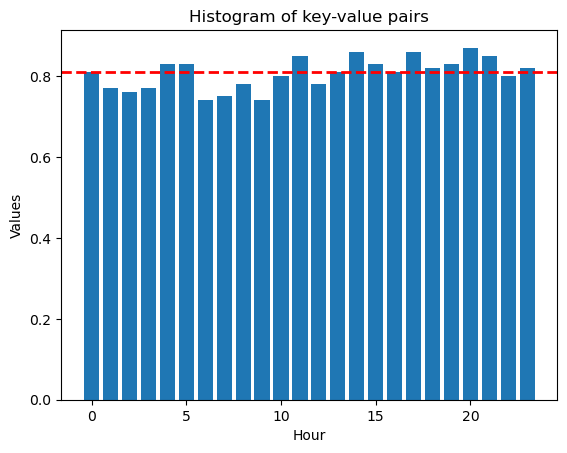

In [254]:
# Visualise accuracy by hour with a histogram
import matplotlib.pyplot as plt
plt.bar(hour_acc_prcnt.keys(), hour_acc_prcnt.values())
plt.axhline(avg_hour_prcnt, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Values')
plt.title('Histogram of key-value pairs')
plt.show()

2c) In this part we are actually doing the same calculations as in the 2b part but this time we are doing it for each month. 

In [255]:
# Check the accuracy for each month

# Create an empty dictionary to store the counts for each hour
month_counts = {}

# Iterate through the list of dicts
for entry in smp_list_frcst:
    month = datetime.strptime(entry['date'], '%Y-%m-%dT%H:%M:%S.%f%z').month
    if month in month_counts:
        month_counts[month] += 1
    else:
        month_counts[month] = 1

# Print the dictionary of month counts
month_counts = dict(sorted(month_counts.items()))
print(month_counts)
total = sum(month_counts.values())
print('Total actual count: ',total)

# Initiate month accuracy dictionary
month_acc_counts = {month: 0 for month in range(12)}
i=0
while i < len(smp_list_frcst):
    month = datetime.strptime(smp_list_frcst[i]['date'], '%Y-%m-%dT%H:%M:%S.%f%z').month
    if smp_list_frcst[i]['smpDirection'] == smp_list[i+3]['smpDirection']:
        month_acc_counts[month] += 1
    i+=1

print(month_acc_counts)

# A quick checksum to see if our finding are in accordance with the our findings in the 'whole data' part
# it was accurate for 5910 entries in total
total = sum(month_acc_counts.values())
print('Total accurate count: ',total)

month_acc_prcnt = {}
for key in month_counts.keys():
    month_acc_prcnt[key] = month_acc_counts[key] / month_counts[key]

month_acc_prcnt = {k: round(v, 2) for k, v in month_acc_prcnt.items()}
print('Accuracy by month for t-3')
print(month_acc_prcnt)

total_value = 0
for value in month_acc_prcnt.values():
    total_value += value

avg_month_prcnt = round(total_value / len(month_acc_prcnt),2)
print("Average value:", avg_month_prcnt)

{1: 741, 2: 672, 3: 744, 4: 720, 5: 744, 6: 720, 7: 744, 8: 744, 9: 720, 10: 744, 11: 24}
Total actual count:  7317
{0: 0, 1: 602, 2: 546, 3: 675, 4: 543, 5: 572, 6: 574, 7: 588, 8: 652, 9: 567, 10: 570, 11: 21}
Total accurate count:  5910
Accuracy by month for t-3
{1: 0.81, 2: 0.81, 3: 0.91, 4: 0.75, 5: 0.77, 6: 0.8, 7: 0.79, 8: 0.88, 9: 0.79, 10: 0.77, 11: 0.88}
Average value: 0.81


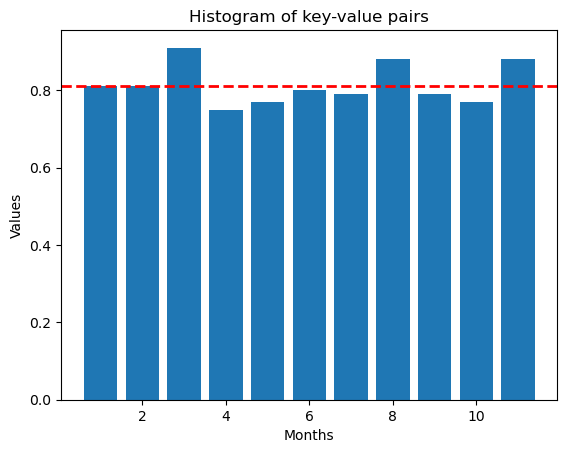

In [256]:
# Visualise accuracy by month with a histogram
plt.bar(month_acc_prcnt.keys(), month_acc_prcnt.values())
plt.axhline(avg_month_prcnt, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Months')
plt.ylabel('Values')
plt.title('Histogram of key-value pairs')
plt.show()

2d)Comments on performance of this forecast:

I think since the data can only take 3 values (-1,0,1 for YAL,DNG,YAT) the only relevant measurement to look at is the accuracy. 

It was 80.77 % for the whole data

81 % avg on hourly while 20:00 is being the most accurate with 87 %

81 % avg on monthly while March is being the most accurate with 91 %

To comment on this more I've done a regression test(in 3e part later on). In the regression R^2 was rather low.

The accuracy of a forecast above 80.77% indicates that the forecast is close to the actual data, but a low R^2 value of 0.44 in the regression analysis suggests that there is only a weak linear relationship between the actual and forecasted values. This could mean that there are other factors affecting the actual data that are not captured in the forecast model. In other words, while the forecast is accurate, it is not a good predictor of the actual values. Therefore, additional analysis or a different forecasting method may be needed to better explain the actual data.

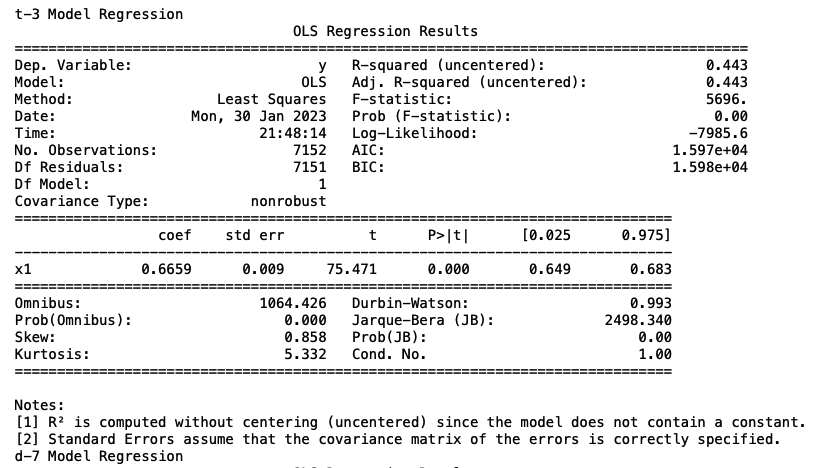



3a) The rule is changed to d-7 instead of t-3 so we will do some changes in the code accordingly. So what we need to do is actually calculate everything for t-168 (7*24 hrs -> 168hrs) instead of t-3

The accuracy dropped to 71.9 % (for the whole data)

In [213]:
# Strip smpList from JSON 
smp_list = data['body']['smpList']
#print(smp_list)
# I strip directions from the list just to check if it contains
# anything other than YAL(Yük Al), YAT(Yük At) and DNG(Denge)
# As stated in the case study description
# I'm changing 'YAT' to 1 'YAL' to -1 and 'DNG' to 0
for i in smp_list:
    if i['smpDirection'] == 'YAT':
        i['smpDirection'] = 1
    elif i['smpDirection'] == 'YAL':
        i['smpDirection'] = -1
    elif i['smpDirection'] == 'DNG':
        i['smpDirection'] = 0
smp_directions = [i['smpDirection'] for i in smp_list]


# We need to use copy package's deepcopy method since smp_list is a list of lists
smp_list_frcst = copy.deepcopy(smp_list)

i = 0
k = 168
while k < len(smp_list_frcst):
    smp_list_frcst[k]['smpDirection'] = smp_list[i]['smpDirection']
    i+=1
    k+=1

# We need to prune first 168 entries to have only the forecasted values
smp_list_frcst = copy.deepcopy(smp_list_frcst[168:])
# Get a copy of forecast directions for the t-test
forecast2 = [i['smpDirection'] for i in smp_list_frcst]
forecast2bkp = [i['smpDirection'] for i in smp_list_frcst]

# Check the accuracy for whole data

i = 168
k = 0
cnt = 0
while k < len(smp_list_frcst):
    if smp_list_frcst[k]['smpDirection'] == smp_list[i]['smpDirection']:
        cnt+=1
    i+=1
    k+=1
# print(cnt)
print ('Accuracy for the whole data: ',cnt, '/',len(smp_list_frcst),'= %',
       round((cnt/len(smp_list_frcst)*100),2))






Accuracy for the whole data:  5142 / 7152 = % 71.9


3b) Accuracy of eacy hour

The best one was 19:00 with 85 % accuracy.

{0: 298, 1: 298, 2: 298, 3: 298, 4: 298, 5: 298, 6: 298, 7: 298, 8: 298, 9: 298, 10: 298, 11: 298, 12: 298, 13: 298, 14: 298, 15: 298, 16: 298, 17: 298, 18: 298, 19: 298, 20: 298, 21: 298, 22: 298, 23: 298}
Total actual count:  7152
{0: 197, 1: 198, 2: 198, 3: 180, 4: 185, 5: 190, 6: 209, 7: 200, 8: 224, 9: 230, 10: 216, 11: 216, 12: 189, 13: 191, 14: 222, 15: 229, 16: 224, 17: 250, 18: 249, 19: 253, 20: 246, 21: 242, 22: 204, 23: 200}
Total accurate count:  5142
Accuracy by hour for d-7
{0: 0.66, 1: 0.66, 2: 0.66, 3: 0.6, 4: 0.62, 5: 0.64, 6: 0.7, 7: 0.67, 8: 0.75, 9: 0.77, 10: 0.72, 11: 0.72, 12: 0.63, 13: 0.64, 14: 0.74, 15: 0.77, 16: 0.75, 17: 0.84, 18: 0.84, 19: 0.85, 20: 0.83, 21: 0.81, 22: 0.68, 23: 0.67}
Average value: 0.72


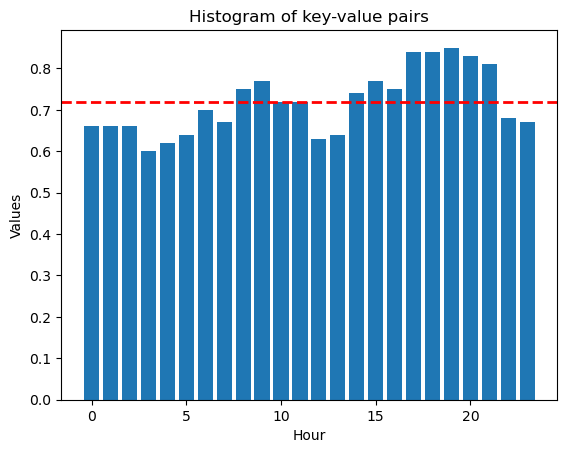

In [166]:
# Check the accuracy for each hour
from datetime import datetime
# Create an empty dictionary to store the counts for each hour
hour_counts = {}

# Iterate through the list of dicts
for entry in smp_list_frcst:
    # Extract the hour from the 'date' field
    hour = datetime.strptime(entry['date'], '%Y-%m-%dT%H:%M:%S.%f%z').hour
    # If the hour is already in the dictionary, increment the count
    if hour in hour_counts:
        hour_counts[hour] += 1
    # If the hour is not in the dictionary, add it with a count of 1
    else:
        hour_counts[hour] = 1

# Print the dictionary of hour counts
hour_counts = dict(sorted(hour_counts.items()))
print(hour_counts)
total = sum(hour_counts.values())
print('Total actual count: ',total)

# Initiate hour accuracy dictionary
hour_acc_counts = {hour: 0 for hour in range(24)}
#print(hour_acc_counts)
i=0
time_delta=168
while i < len(smp_list_frcst):
    hour = datetime.strptime(smp_list_frcst[i]['date'], '%Y-%m-%dT%H:%M:%S.%f%z').hour
    if smp_list_frcst[i]['smpDirection'] == smp_list[i+time_delta]['smpDirection']:
        hour_acc_counts[hour] += 1
    i+=1

print(hour_acc_counts)

# A quick checksum to see if our finding are in accordance with the our findings in the 'whole data' part
# it was accurate for 5142 entries in total
total = sum(hour_acc_counts.values())
print('Total accurate count: ',total)

hour_acc_prcnt = {}
for key in hour_counts.keys():
    hour_acc_prcnt[key] = hour_acc_counts[key] / hour_counts[key]

hour_acc_prcnt = {k: round(v, 2) for k, v in hour_acc_prcnt.items()}
print('Accuracy by hour for d-7')
print(hour_acc_prcnt)
total_value = 0
for value in hour_acc_prcnt.values():
    total_value += value

avg_hour_prcnt = round(total_value / len(hour_acc_prcnt),2)
print("Average value:", avg_hour_prcnt)

# Visualise accuracy by hour with a histogram
import matplotlib.pyplot as plt
plt.bar(hour_acc_prcnt.keys(), hour_acc_prcnt.values())
plt.axhline(avg_hour_prcnt, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Values')
plt.title('Histogram of key-value pairs')
plt.show()

3c)Accuracy of each month

The best ones were March and August with 85 % accuracy. 

{1: 576, 2: 672, 3: 744, 4: 720, 5: 744, 6: 720, 7: 744, 8: 744, 9: 720, 10: 744, 11: 24}
Total actual count:  7152
{0: 0, 1: 406, 2: 524, 3: 631, 4: 500, 5: 450, 6: 517, 7: 449, 8: 630, 9: 501, 10: 515, 11: 19}
Total accurate count:  5142
Accuracy by month for d-7
{1: 0.7, 2: 0.78, 3: 0.85, 4: 0.69, 5: 0.6, 6: 0.72, 7: 0.6, 8: 0.85, 9: 0.7, 10: 0.69, 11: 0.79}
Average value: 0.72


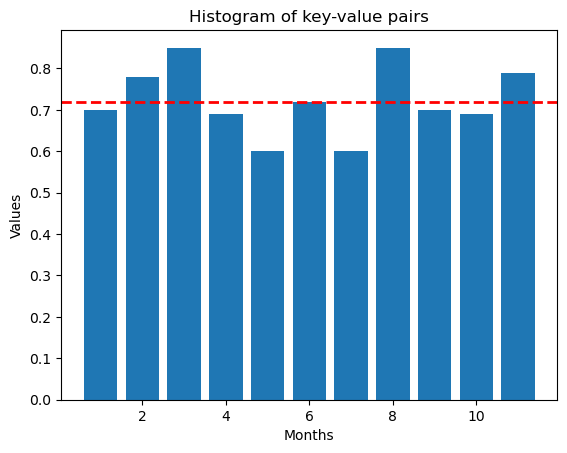

In [167]:
# Check the accuracy for each month

# Create an empty dictionary to store the counts for each hour
month_counts = {}

# Iterate through the list of dicts
for entry in smp_list_frcst:
    month = datetime.strptime(entry['date'], '%Y-%m-%dT%H:%M:%S.%f%z').month
    if month in month_counts:
        month_counts[month] += 1
    else:
        month_counts[month] = 1

# Print the dictionary of month counts
month_counts = dict(sorted(month_counts.items()))
print(month_counts)
total = sum(month_counts.values())
print('Total actual count: ',total)

# Initiate month accuracy dictionary
month_acc_counts = {month: 0 for month in range(12)}
i=0
time_delta=168
while i < len(smp_list_frcst):
    month = datetime.strptime(smp_list_frcst[i]['date'], '%Y-%m-%dT%H:%M:%S.%f%z').month
    if smp_list_frcst[i]['smpDirection'] == smp_list[i+time_delta]['smpDirection']:
        month_acc_counts[month] += 1
    i+=1

print(month_acc_counts)

# A quick checksum to see if our finding are in accordance with the our findings in the 'whole data' part
# it was accurate for 5142 entries in total
total = sum(month_acc_counts.values())
print('Total accurate count: ',total)

month_acc_prcnt = {}
for key in month_counts.keys():
    month_acc_prcnt[key] = month_acc_counts[key] / month_counts[key]

month_acc_prcnt = {k: round(v, 2) for k, v in month_acc_prcnt.items()}
print('Accuracy by month for d-7')
print(month_acc_prcnt)

total_value = 0
for value in month_acc_prcnt.values():
    total_value += value

avg_month_prcnt = round(total_value / len(month_acc_prcnt),2)
print("Average value:", avg_month_prcnt)

# Visualise accuracy by month with a histogram
plt.bar(month_acc_prcnt.keys(), month_acc_prcnt.values())
plt.axhline(avg_month_prcnt, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Months')
plt.ylabel('Values')
plt.title('Histogram of key-value pairs')
plt.show()

3d) Comments on the performance of this method:

Accuracy was 71.9 % for the whole data

72 % avg on hourly while 19:00 is being the most accurate with 85 %

72 % avg on monthly while March and August are being the most accurate with 85 %

I've done a regression test for this method too(in 3e part later on). In the regression R^2 was lower (0.233) than the first method.

3e) To make this comparison, we can compare the following attributes of the forecasts: Accuracy, Mean absolute error (MAE) ,Mean squared error (MSE).

Accuracy of t-3 method for the whole data: % 80.77

Accuracy of d-7 method for the whole data: % 71.9

MAE and RMSE readings were also better for the first forecasting method:

Mean Absolute Error for Forecast1(t-3):  0.34507829977628635

Root Mean Squared Error for Forecast1(t-3):  0.6557606263982103

Mean Absolute Error for Forecast2(d-7):  0.5258668903803132

Root Mean Squared Error for Forecast2(d-7):  1.0155201342281879

The first method was also better by 9 % than the second method both in hourly and monthly forecast comparisons. 

I will also conduct a t-test for the accuracy of the results. This test will be done only for the 'whole data' and to do this, forecast errors of the both methods will be used. 

Before we dive into a t-test the following assumptions should be checked:

1- Normality of the data: The t-test assumes that the data being compared is normally distributed. We can use visual methods like histograms and normal probability plots to assess the normality of the data. (Will be checked visually and also using Shapiro-Wilk test)(Even though the normality assumption is said to be not too important and would lead to similar results with more refined approaches like Mann-Whitney U test, I wanted to use Mann-Whitney U test)(Normality assumption failed.)

2- Independence of the samples: The samples being compared should be independent and not influenced by one another.(I did a correlation test for this part and the forecast errors appeared to be uncorrelated with low correlation coefficient.)(This assumption holds.)

3- Sample size: For small sample sizes, the t-test may not be as accurate, especially if the data is not normally distributed. A sample size of at least 30 is generally considered sufficient for the t-test to provide accurate results.(This is ok.)

4- Appropriate choice of test: The t-test assumes equal variances in the two groups being compared. If the variances are unequal, you should use a Welch's t-test instead of the standard t-test. (Variances were not equal so I should proceed with Mann-Whitney U test.)

5- Assumptions of equal variances and equal sample sizes are not met: In such cases, you should use a Mann-Whitney U test or a Wilcoxon signed-rank test.(I tried with both unequal and equal sample sizes and the result wasn't too different.)


In [247]:
# A function to calculate forecast errors

def calculate_forecast_error(actual, forecast): 
    sample_delta = abs(len(actual)-len(forecast))
    if len(forecast)<len(actual):
        actual = actual[sample_delta:]
    else:
        forecast = forecast[sample_delta:]
    #print(len(forecast),len(actual))    
    forecast_error = [actual[i]-forecast[i] for i in range(len(actual))]
    return forecast_error
# A function to calculate MSE 
def mean_squared_error(actual, forecast):
    sample_delta = abs(len(actual)-len(forecast))
    if len(forecast)<len(actual):
        actual = actual[sample_delta:]
    else:
        forecast = forecast[sample_delta:]
    mse = 0
    for i in range(len(actual)):
        mse += (actual[i] - forecast[i]) ** 2
    mse /= len(actual)
    return mse
# A function to calculate MAE
def mean_absolute_error(actual, forecast):
    sample_delta = abs(len(actual)-len(forecast))
    if len(forecast)<len(actual):
        actual = actual[sample_delta:]
    else:
        forecast = forecast[sample_delta:]
    mae = 0
    for i in range(len(actual)):
        mae += abs(actual[i] - forecast[i])
    mae /= len(actual)
    return mae

smp_directions = smp_directions_bkp
forecast1_err = calculate_forecast_error(smp_directions, forecast1)
forecast2_err = calculate_forecast_error(smp_directions, forecast2)

# Since it is better to do the t-test with equal sample size
# I'm starting this part by pruning the long sample set 
# I've also tried the ttest in scipy package without equalizing the sample size
# but the p-value of that test was significantly higher
# So, It was better to use equal sample sized forecasts errors

sample_delta = abs(len(forecast1_err)-len(forecast2_err))
if len(forecast1_err)<len(forecast2_err):
    forecast2_err = forecast2_err[sample_delta:]
else:
    forecast1_err = forecast1_err[sample_delta:]

print('Mean Absolute Error for Forecast1(t-3): ',mean_absolute_error(actual, forecast1))
print('Mean Absolute Error for Forecast2(d-7): ',mean_absolute_error(actual, forecast2))

print('Root Mean Squared Error for Forecast1(t-3): ',mean_squared_error(actual, forecast1))
print('Root Mean Squared Error for Forecast2(d-7): ',mean_squared_error(actual, forecast2))


Mean Absolute Error for Forecast1(t-3):  0.34507829977628635
Mean Absolute Error for Forecast2(d-7):  0.5258668903803132
Root Mean Squared Error for Forecast1(t-3):  0.6557606263982103
Root Mean Squared Error for Forecast2(d-7):  1.0155201342281879


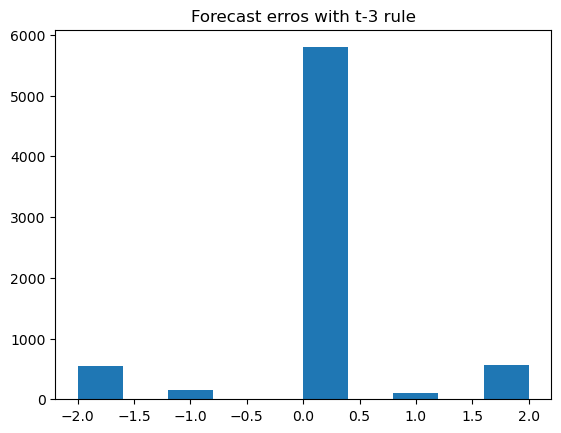

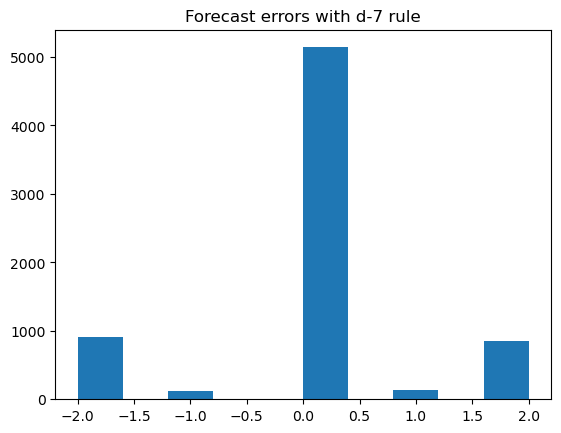

Shapiro-Wilk test for t-3 rule
Statistics=0.602, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for d-7 rule
Statistics=0.715, p=0.000
Sample does not look Gaussian (reject H0)
Pearson Correlation test for forecast1_err and forecast2_err
Correlation: 0.36995051067681095
P-value: 7.773390760726707e-231
Levene test for forecast1_err and forecast2_err
The variances are not equal (reject H0)
T-test for forecast1_err and forecast2_err
P value:  0.37497993123734596
There is not a significant difference between the two forecasts.
Mann-Whitney U test for forecast1_err and forecast2_err
P value:  0.5899253294896502
There is not a significant difference between the two forecasts.


In [250]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import levene

# # check count of the directions out of curiosity
# smp_directions_yat = list(filter(lambda x: x['smpDirection'] == 1, smp_list))
# smp_directions_yal = list(filter(lambda x: x['smpDirection'] == -1, smp_list))
# smp_directions_dng = list(filter(lambda x: x['smpDirection'] == 0, smp_list))
# print('ACTUAL counts')
# print('YAT count')
# print(len(smp_directions_yat))
# print('YAL count')
# print(len(smp_directions_yal))
# print('DNG count')
# print(len(smp_directions_dng))


# Check the normality assumption, if that fails we'll use the Mann-Whitney U test
# We can check it both visually and also using Shapiro-Wilk test

plt.title('Forecast erros with t-3 rule')
plt.hist(forecast1_err)
plt.show()

plt.title('Forecast errors with d-7 rule')
plt.hist(forecast2_err)
plt.show()


# Shapiro-Wilk test H0: 'Sample comes from a normal distribution'
# Conduct the Shapiro-Wilk test for normality for forecast1
print('Shapiro-Wilk test for t-3 rule')
stat, p = shapiro(forecast1_err)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
# Conduct the Shapiro-Wilk test for normality for forecast2
print('Shapiro-Wilk test for d-7 rule')
stat, p = shapiro(forecast2_err)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

    
# Perform the Pearson correlation test
# If the p-value is less than a certain significance level (e.g. 0.05),
# it suggests that there is a significant linear relationship between the two arrays

print('Pearson Correlation test for forecast1_err and forecast2_err')
correlation, p_value = pearsonr(forecast1_err, forecast2_err)

print("Correlation:", correlation)
print("P-value:", p_value)
    
# To check for equal variances between two datasets before performing a t-test, you can use the Levene's test
# Note: The null hypothesis in these tests is that the variances are equal, and 
# if the p-value is less than the significance level (e.g. 0.05), 
# then we reject the null hypothesis and conclude that the variances are not equal.

print('Levene test for forecast1_err and forecast2_err')
statistic, p_value = levene(forecast1_err, forecast2_err)
if p_value > 0.05:
    print("The variances are equal (fail to reject H0)")
else:
    print("The variances are not equal (reject H0)")

# Perform t-test
print('T-test for forecast1_err and forecast2_err')
t, p_value = stats.ttest_ind(forecast1_err, forecast2_err, equal_var=False)

# Check p-value
print('P value: ', p_value)
if p_value < 0.05:
    print("There is a significant difference between the two forecasts.")
else:
    print("There is not a significant difference between the two forecasts.")

# Perform the Mann-Whitney U test
print('Mann-Whitney U test for forecast1_err and forecast2_err')
statistic, p_value = mannwhitneyu(forecast1_err, forecast2_err)

print("P value: ", p_value)

# Check p-value
if p_value < 0.05:
    print("There is a significant difference between the two forecasts.")
else:
    print("There is not a significant difference between the two forecasts.")

3e) After looking at these results, we can say that even the first method is superior to the second, there isn't a significant difference between the two forecasts.

To gain more insight we can perform a regression tests to see which forecasting method is explain the actual data better. 


In [216]:
import statsmodels.api as sm
# smp_directions = [i['smpDirection'] for i in smp_list] remeber we had actual data in smp_directions
# from the first part. But we need to prune it before doing the regression analysis

actual = smp_directions

sample_delta = abs(len(forecast1)-len(actual))
if len(forecast1)<len(actual):
    actual = actual[sample_delta:]
else:
    forecast1 = forecast1[sample_delta:]
#print(len(forecast1),len(actual))


# Fit a simple linear regression model for each forecasting data
model1 = sm.OLS(actual, forecast1).fit()
model2 = sm.OLS(actual, forecast2).fit()

# Print the summary of the regression models
print('t-3 Model Regression')
print(model1.summary())
print('d-7 Model Regression')
print(model2.summary())

t-3 Model Regression
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.443
Model:                            OLS   Adj. R-squared (uncentered):              0.443
Method:                 Least Squares   F-statistic:                              5696.
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                        0.00
Time:                        21:48:14   Log-Likelihood:                         -7985.6
No. Observations:                7152   AIC:                                  1.597e+04
Df Residuals:                    7151   BIC:                                  1.598e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

3f) Even though the t-3 rule was superior to d-7 method there wasn't too much of an accuracy difference between these two methods (1st method accuracy: 80.77%, 2nd method accuracy: 71.90%) Nonetheless, since t-3 was more accurate and we see that this prediction explained the model better than the d-7 method (R-squared t-3 model (0.443)>R-squared of d-7(0.233)), I'd suggest using the first method. 

However, we might find a better t-x model that might have predicted the actual data better than these two. We could write an optimisation code that would seek the best performing time delta starting from t-1 to up to let's say, 1 month. And we could've checked the accuracy for the whole data. We could save this data in a dictionary like {t : accuracy} 

In the output of the code below, we can see the best performing deltas.

In [239]:
# Let's say we want to seek the optimal time delta starting from t-1 to t-5.
# We can make this 168 to check everything between t-1 and d-7 and see what is the optimal value
optimisation_delta = 168 

accuracy_by_delta = {delta: 0 for delta in range(1,optimisation_delta+1)}

for j in range(1,optimisation_delta+1):
    # A simple optimisation module to find the best time delta
    # Strip smpList from JSON 
    smp_list = data['body']['smpList']

    # We need to use copy package's deepcopy method since smp_list is a list of lists
    smp_list_frcst = copy.deepcopy(smp_list)
    i = 0
    k = j
    while k < len(smp_list_frcst):
        smp_list_frcst[k]['smpDirection'] = smp_list[i]['smpDirection']
        i+=1
        k+=1

    # We need to prune first j entries to have only the forecasted values
    smp_list_frcst = copy.deepcopy(smp_list_frcst[j:])

    # Check the accuracy for whole data
    i = j
    k = 0
    cnt = 0
    while k < len(smp_list_frcst):
        if smp_list_frcst[k]['smpDirection'] == smp_list[i]['smpDirection']:
            cnt+=1
        i+=1
        k+=1
    try:
        accuracy = round((cnt/len(smp_list_frcst)*100),2)
        accuracy_by_delta[j] = accuracy
        print ('Accuracy for delta: ',j,'is = ' ,accuracy)
    except ZeroDivisionError:
        accuracy = 0
        accuracy_by_delta[j] = accuracy
        print ('Accuracy for delta: ',j,'is = ' ,accuracy)

# print ('Accuracies by time deltas: ')
# print (accuracy_by_delta)

# Then we can check the most optimal let's say 3 time deltas
# sort the dictionary by values in descending order
sorted_accuracy_by_delta = {k: v for k, v in sorted(accuracy_by_delta.items(), key=lambda item: item[1], reverse=True)}

# get the keys of the first 3 elements
x=20
top_x_keys = list(sorted_accuracy_by_delta.keys())[:x]

print ('The most optimal',x,' deltas are: ',top_x_keys)

Accuracy for delta:  1 is =  88.58
Accuracy for delta:  2 is =  83.85
Accuracy for delta:  3 is =  80.77
Accuracy for delta:  4 is =  78.25
Accuracy for delta:  5 is =  76.8
Accuracy for delta:  6 is =  75.66
Accuracy for delta:  7 is =  74.89
Accuracy for delta:  8 is =  74.22
Accuracy for delta:  9 is =  73.51
Accuracy for delta:  10 is =  73.01
Accuracy for delta:  11 is =  72.51
Accuracy for delta:  12 is =  72.24
Accuracy for delta:  13 is =  71.92
Accuracy for delta:  14 is =  72.3
Accuracy for delta:  15 is =  72.1
Accuracy for delta:  16 is =  71.85
Accuracy for delta:  17 is =  71.53
Accuracy for delta:  18 is =  71.72
Accuracy for delta:  19 is =  71.54
Accuracy for delta:  20 is =  71.63
Accuracy for delta:  21 is =  72.05
Accuracy for delta:  22 is =  72.38
Accuracy for delta:  23 is =  72.41
Accuracy for delta:  24 is =  72.7
Accuracy for delta:  25 is =  71.9
Accuracy for delta:  26 is =  70.67
Accuracy for delta:  27 is =  69.81
Accuracy for delta:  28 is =  69.3
Accurac